# Code Assigment 1

For this assignment you will use the following SVM implementation for classifying these datasets:
https://archive.ics.uci.edu/ml/datasets/banknote+authentication
https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

You should:

1) Specify which Machine Learning problem are you solving.

2) Provide a short summary of the features and the labels you are working on.

3) Please answer the following questions: a) Are these datasets linearly separable? b) Are these datasets randomly chosen and c) The sample size is enough to guarantee generalization.

4) Provide an explanation how and why the code is working. You can add comments and/or formal explanations into the notebook.

5) Show some examples to illustrate that the method is working properly.

6) Provide quantitative evidence for generalization using the provided dataset.


**1)** Realizaremos la implementación de una máquina de soporte vectorial para resolver un problema de clasificación binaria. En particular, los datos presentados en el data set "Occupancy detection" fueron recolectados minuto a minuto haciendo mediciones en una habitación donde puede encontrarse una persona o no, esta variable es registrada con el nombre de "Ocuppancy".

**Descripción de una SVM**

En principio, el ojetivo de una SVM es encontrar un hiperplano que maximice la distancia entre puntos que representen elementos de dos clases distintas. De manera que sea posible determinar si un elemento que no se encontraba inicialmente en el conjunto de entrenamiento, pertenece a alguna de estas dos clases.

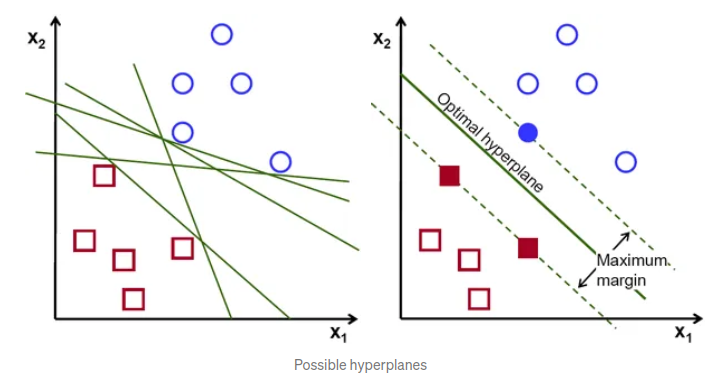



En este contexto, un hiperplano jugará el papel de una frontera de decisión, de manera que la clasificación de un punto se hará tomando en cuenta en que lado del hiperplano se encuentre. Es importante señalar que la dimensión del hiperplano depende de la cantidad de características con las que se sea entrenado el algoritm. De manera que sí se usan solo dos características, el hiperplano será una línea (una dimensión). En caso de que se trabaje con tres características, el hiperplano será un plano(dos dimensiones). Es decir, para *n* características se usará un hiperplano de *n-1* dimensiones.

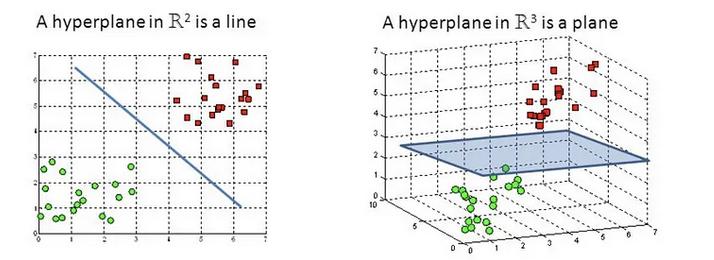

Los vectores de soporte serán los puntos del dataset que se encuentren más cerca del hiperplano. Más adelante haremos uso de estos para ajustar los parametros del modelo.

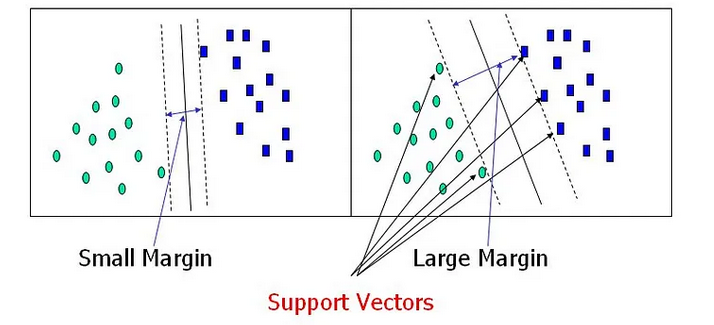

Referencia: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [2]:
#Librerias utilizadas
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import numpy as np
import scipy
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import weibull_min
from scipy.optimize import minimize
style.use('ggplot') 


drive.mount('/content/drive')




Mounted at /content/drive


**Descripción de las covariables**


Date: Año, mes, día, hora, minuto, segundo en el que se realizó la medición

*  *Temperature:* Temperatura medida en grados Celsius
*   *Humidity:* Porcentaje de humedad relativa
*   *Luz:*  Medida en Lux
*   *CO2:*  Medido en partes por millón
*   *Humidity Ratio*, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
*   *Occupancy:* Presencia o ausencia. Se asigna 1 o -1, respectivamente.

















In [3]:
#Montaje de la carpeta de trabajo
os.chdir('/content/drive/MyDrive/svm')

#Lectura de data sets

#Entrenamiento
data_occupancy=pd.read_csv('datatraining.txt',sep=',',header=0,names=["Date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"],
                               dtype={"Date":str,"Temperature":np.float64,"Humidity":np.float64,"Light":np.float64,
                              "CO2":np.float64,"HumidityRatio":np.float64,"Occupancy":int},parse_dates=[1],infer_datetime_format=True)
#Validación
data_test=pd.read_csv('datatest.txt',sep=',',header=0,names=["Date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"],
                               dtype={"Date":str,"Temperature":np.float64,"Humidity":np.float64,"Light":np.float64,
                              "CO2":np.float64,"HumidityRatio":np.float64,"Occupancy":int},parse_dates=[1],infer_datetime_format=True)

#test


#Redondear a dos cifras
data_occupancy[['Temperature']] = data_occupancy[['Temperature']].astype(float).round(3)
data_occupancy[['CO2']] = data_occupancy[['CO2']].astype(float).round(3)
data_occupancy[['Humidity']] = data_occupancy[['Humidity']].astype(float).round(3)
data_occupancy["Occupancy"]=data_occupancy[['Occupancy']].replace(0,-1)
data_test[['Temperature']] = data_test[['Temperature']].astype(float).round(3)
data_test["Occupancy"]=data_test[['Occupancy']].replace(0,-1)





In [ ]:
#Estadísticas descriptivas
data_occupancy.describe()


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731509,119.519375,606.546242,0.003863,-0.575341
std,1.016917,5.531210,194.755805,314.320874,0.000852,0.817964
min,19.000000,16.745000,0.000000,412.750000,0.002674,-1.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,-1.000000
50%,20.390000,26.222000,0.000000,453.500000,0.003801,-1.000000
75%,21.390000,30.533000,256.375000,638.833500,0.004352,-1.000000
max,23.180000,39.118000,1546.333333,2028.500000,0.006476,1.000000


In [15]:
#Búsqueda de valores NA's
def missings(x):
            a = sum(x.isna())
            b = 100*np.mean(x.isna())
            c = pd.Series({"Missings": a,"%Missings": b})
            return(c)
data_occupancy.apply(missings,axis=0)
#No hay presencia de datos faltantes

,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Missings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%Missings,0.0,0.0,0.0,0.0,0.0,0.0,0.0


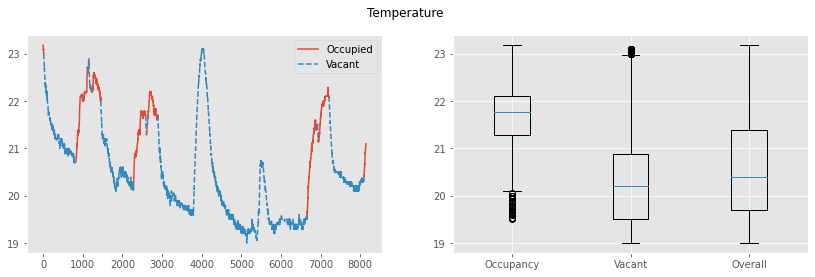

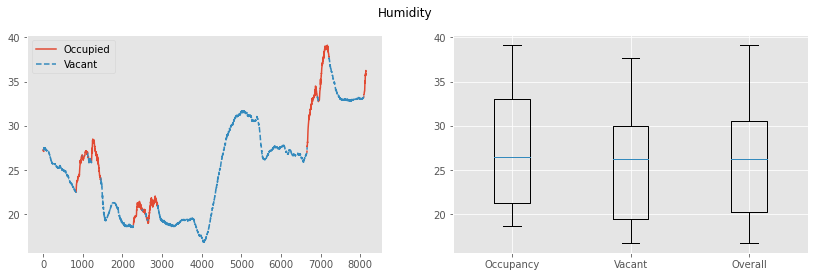

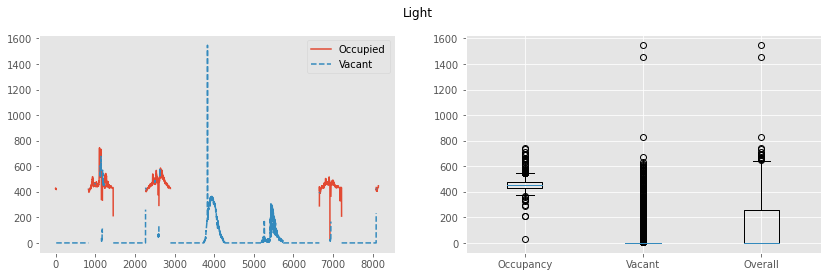

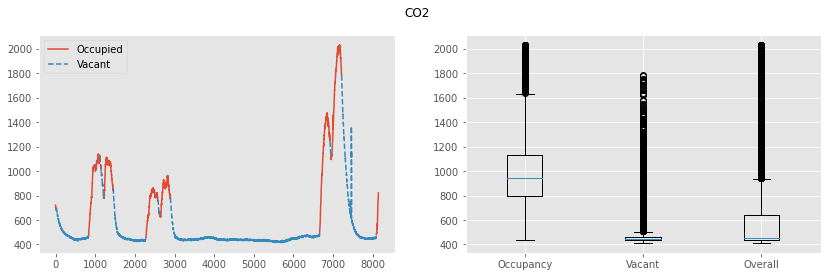

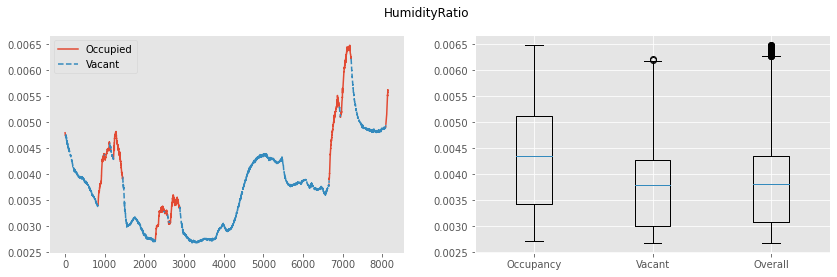

In [ ]:
#Comportamiento temporal de las variables
#Redondear a dos cifras
data_occupancy[['Temperature','Humidity','Light','CO2']] = data_occupancy[['Temperature','Humidity','Light','CO2']].astype(float).round(2)

def occupancy_plot(df, cat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    
    fig.suptitle(cat)
    ax1.plot(np.where(df.Occupancy==1, df[cat], None), label='Occupied')
    ax1.plot(np.where(df.Occupancy==-1, df[cat], None), label='Vacant', ls='--')
    ax1.grid()
    ax1.legend()
    
    ax2.boxplot([df[cat][df.Occupancy==1], df[cat][df.Occupancy==-1], df[cat]])
    ax2.set_xticklabels(['Occupancy', 'Vacant', 'Overall'])


for i in range(1, 6):
    occupancy_plot(data_occupancy, data_occupancy.columns[i])

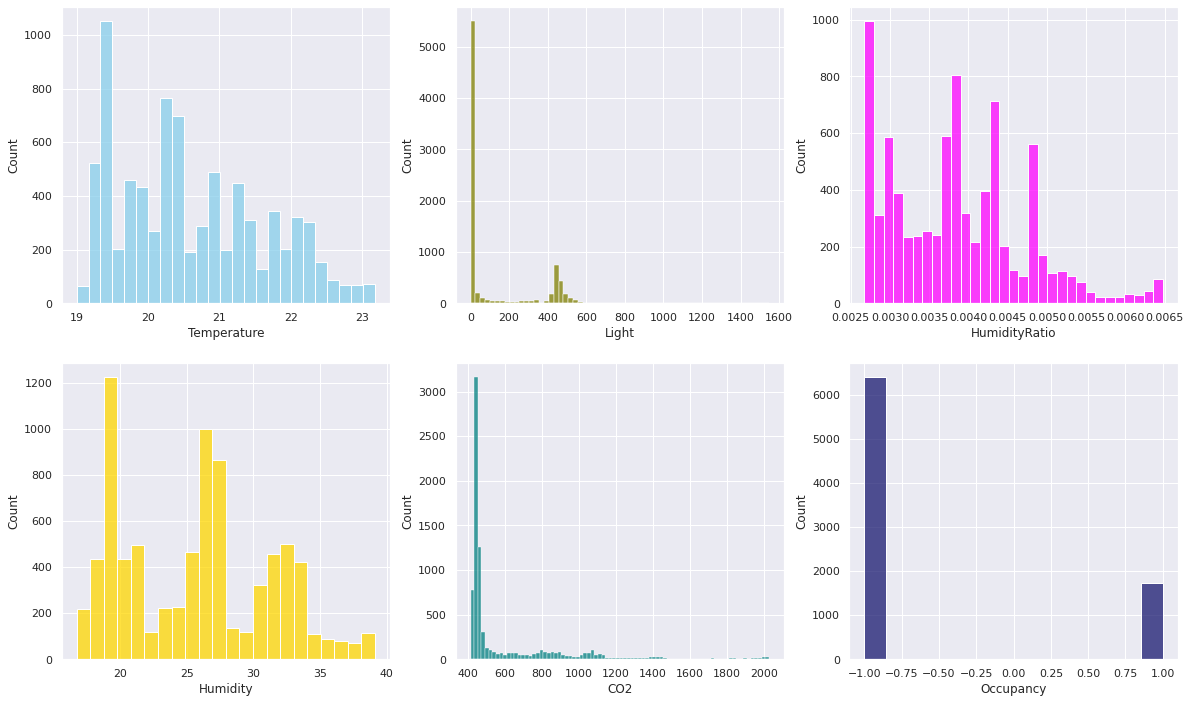

In [ ]:
#Frecuencias
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

sns.histplot(data=data_occupancy["Temperature"], color="skyblue", ax=axs[0, 0])
sns.histplot(data=data_occupancy["Light"], color="olive", ax=axs[0, 1])
sns.histplot(data=data_occupancy["Humidity"], color="gold", ax=axs[1, 0])
sns.histplot(data=data_occupancy["CO2"], color="teal", ax=axs[1, 1])
sns.histplot(data=data_occupancy["HumidityRatio"], color="magenta", ax=axs[0, 2])
sns.histplot(data=data_occupancy["Occupancy"], color="midnightblue", ax=axs[1, 2])
plt.show()



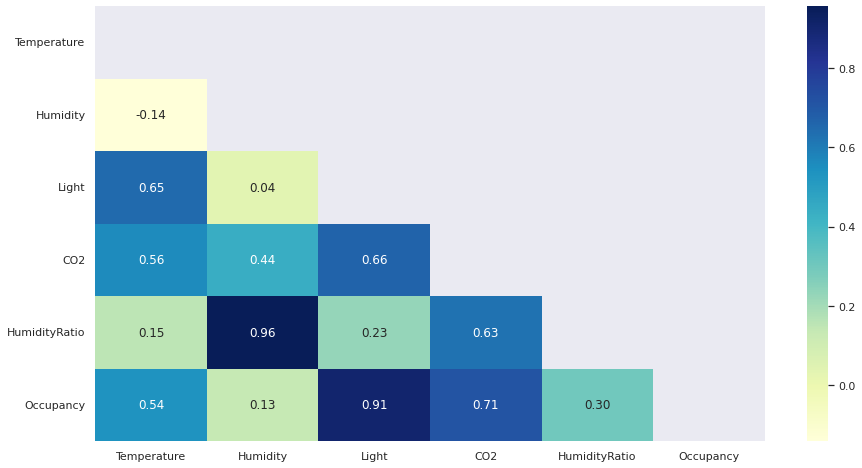

In [ ]:
mask = np.triu(np.ones_like(data_occupancy.corr()))
plt.figure(figsize = (15,8))
sns.heatmap(data_occupancy.corr(),annot=True, fmt="1.2f", mask=mask, cmap="YlGnBu")
plt.yticks(rotation=0)
plt.show()

La información que puede contribuir la variable "Light" al modelo nos da un indicio que los datos son linealmente separables, pues al tener una correlación baja con las demás variables estaría aportando información más significativa que las variables estén altamente correlacionadas. Esto será más evidente cuando veamos el comportamineto de un clasificador en dos variables.

**3a)**

A modo de ejemplo, ilustraremos el desempeño de la SVM, fijándonos en las variables "*Light*" y "*Humidity*". Es de resaltar que el siguiente algoritmo optimiza únicamente en la primera variable, decidimos continuar la implementación con este algoritmo pues el método usado para la implementación es bastante ineficiente y al trabajar con escalas tan distintas, si se optimizan todas las variables al tiempo, el gradiente se desfaza y el modelo resultante termina siendo inútil.


A pesar de optimizar una sola variable, se tienen buenas medidas de desempeño comparado con la función svm() de la librería scikit-learn. Para hacer las pruebas y ajustar parámetros e hiperparámetros decidimos tomar una muestra aleatoria de 500 observaciones de entrenamiento para poder ver los resultados rápidamente. 

Optimized a step
[-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1

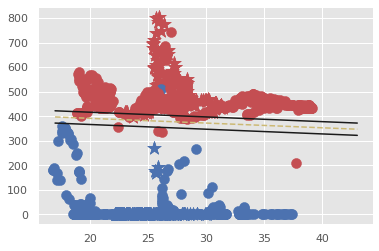

In [ ]:
#Caso dim=2, muy buen desempeño
def listOfTuples(l1, l2):
    return list(map(lambda x, y:[x,y], l1, l2))


import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import random
style.use('ggplot')

np.random.seed(56497)






class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        self.max_feature_value_2 = max(data[1][:,0])
        self.min_feature_value_2 = min(data[1][:,0])
        all_data = None

        # support vectors yi(xi.w+b) = 1
        

        step_sizes = [self.max_feature_value * 0.1,
                      #self.max_feature_value * 0.01,
                      # point of expense:
                      #self.max_feature_value * 0.001,
                      ]

        
        
        # extremely expensive
        b_range_multiple = 2
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                #En este paso se definen los vectores de soporte
                                if not yi*(np.dot(w_t,xi)+b) >= 50:
                                    found_option = False
                                    #print(xi,':',yi*(np.dot(w_t,xi)+b))
                                    
                                if found_option:
                                    opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print("Optimized a step")
                else:
                    w = w - step


            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            
        # for i in self.data:
        #     for xi in self.data[i]:
        #         yi=i
        #         print(xi,':',yi*(np.dot(self.w,xi)+self.b))
         


    def predict(self,features):
        # sign( x.w+b )
        # for i in range(0,len(features)):
        #   x.append(features)
        classification = np.sign(np.sum(np.dot(np.array(features),self.w)+self.b+features+200))
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
            #print(features,np.sum(np.dot(np.array(features),self.w)+self.b+features+30))
        return classification

    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0


        def hyperplane(x,w,b,v):
            return -w[0]*x-b+v

        datarange = (self.min_feature_value_2*0.9,self.max_feature_value_2*1.1)

        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        #(w.x+b) = 1
        #positive support vector hyperplane
        psv1 =hyperplane(hyp_x_min, self.w, self.b,50)
        psv2 =hyperplane(hyp_x_max, self.w, self.b,0)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')


        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -50)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 25)
        db2 = hyperplane(hyp_x_max, self.w, self.b, -25)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()
        
dfa=data_occupancy[data_occupancy["Occupancy"]==1].sample(500)

dfb=data_occupancy[data_occupancy["Occupancy"]==-1].sample(500)

#"Muestra aleatoria"
data_dict = {-1:np.array(listOfTuples(dfb["Humidity"],dfb["Light"])),
             1:np.array(listOfTuples(dfa["Humidity"],dfa["Light"]))
             }

svm = Support_Vector_Machine()
svm.fit(data=data_dict)

#Datos de prueba
#data_p=[data_occupancy["Temperature"],data_occupancy["CO2"]].sample(10)

dt=data_test.sample(500)
predict_us = listOfTuples(dt["Humidity"],dt["Light"])

#predict_us = listOfTuples(data_occupancy["Temperature"].sample(10),data_occupancy["CO2"].sample(10))

x=[]


for p in predict_us:
    svm.predict(p)
    x.append(svm.predict(p))

print(x)


svm.visualize()


In [ ]:
#Matriz de confusión
#Punto 5
predicted =pd.Series(list(map(int, x)),name="predicted")
actual=pd.Series(dt["Occupancy"],name="actual").reset_index(drop=True)
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])

df_confusion 
#Accuracy=97.2%

Predicted,-1,1
Actual,,
-1,314,14
1,0,172


In [ ]:
#Función para crear las tranformaciones
import itertools
x = [1, -1]
a=[p for p in itertools.product(x, repeat=5)]
b = [list(x) for x in a]
b

Ahora bien, para extender esta implementación a más variables debemos ajustar los vectores de transformación, en total 32, modificar la función que transforma las entradas del diccionario en una lista e ingresar todas columnas de interes de los data sets de entrenamiento y de test.

Optimized a step
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0,

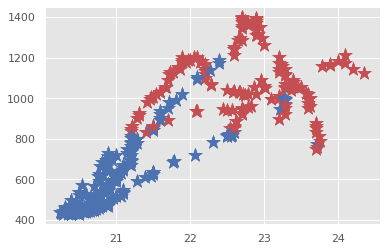

In [154]:
def listOfTuples(l1, l2, l3,l4,l5):
  return list(map(lambda x, y, z, w, t:[x,y,z,w,t], l1, l2, l3,l4,l5))


import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import random
style.use('ggplot')

np.random.seed(56497)




class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1, 1, 1, 1, 1],
                      [1, 1, 1, 1, -1],
                      [1, 1, 1, -1, 1],
                      [1, 1, 1, -1, -1],
                      [1, 1, -1, 1, 1],
                      [1, 1, -1, 1, -1],
                      [1, 1, -1, -1, 1],
                      [1, 1, -1, -1, -1],
                      [1, -1, 1, 1, 1],
                      [1, -1, 1, 1, -1],
                      [1, -1, 1, -1, 1],
                      [1, -1, 1, -1, -1],
                      [1, -1, -1, 1, 1],
                      [1, -1, -1, 1, -1],
                      [1, -1, -1, -1, 1],
                      [1, -1, -1, -1, -1],
                      [-1, 1, 1, 1, 1],
                      [-1, 1, 1, 1, -1],
                      [-1, 1, 1, -1, 1],
                      [-1, 1, 1, -1, -1],
                      [-1, 1, -1, 1, 1],
                      [-1, 1, -1, 1, -1],
                      [-1, 1, -1, -1, 1],
                      [-1, 1, -1, -1, -1],
                      [-1, -1, 1, 1, 1],
                      [-1, -1, 1, 1, -1],
                      [-1, -1, 1, -1, 1],
                      [-1, -1, 1, -1, -1],
                      [-1, -1, -1, 1, 1],
                      [-1, -1, -1, 1, -1],
                      [-1, -1, -1, -1, 1],
                      [-1, -1, -1, -1, -1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        self.max_feature_value_2 = max(data[1][:,0])
        self.min_feature_value_2 = min(data[1][:,0])
        all_data = None

        # support vectors yi(xi.w+b) = 1
        

        step_sizes = [self.max_feature_value * 0.1,
                      #self.max_feature_value * 0.01,
                      # point of expense:
                      #self.max_feature_value * 0.001,
                      ]

        
        
        # extremely expensive
        b_range_multiple = 2
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum,latest_optimum,latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 500:
                                    found_option = False
                                    #print(xi,':',yi*(np.dot(w_t,xi)+b))
                                    
                                if found_option:
                                    opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print("Optimized a step")
                    #print(w)
                    #print(b)
                else:
                    w = w - step


            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            
        # for i in self.data:
        #     for xi in self.data[i]:
        #         yi=i
        #         print(xi,':',yi*(np.dot(self.w,xi)+self.b))
         

    def predict(self,features):
        # sign( x.w+b )
        # x=[]
        # for i in range(0,len(features)):
        #   x.append(features)
        classification = np.sign(np.sum(np.dot(np.array(features),self.w)+self.b+features+750))
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
            #print(features,np.sum(np.dot(np.array(features),self.w)+self.b+features+1200))
        return classification

    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0


        def hyperplane(x,w,b,v):
            return -w[0]*x-b+v

        datarange = (self.min_feature_value_2*0.9,self.max_feature_value_2*1.1)

        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        #(w.x+b) = 1
        #positive support vector hyperplane
        psv1 =hyperplane(hyp_x_min, self.w, self.b,500)
        psv2 =hyperplane(hyp_x_max, self.w, self.b,0)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')


        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -500)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 250)
        db2 = hyperplane(hyp_x_max, self.w, self.b, -250)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()

#"Muestra aleatoria"       
dfa=data_occupancy[data_occupancy["Occupancy"]==1].sample(1000)

dfb=data_occupancy[data_occupancy["Occupancy"]==-1].sample(1000)


data_dict = {-1:np.array(listOfTuples(dfb["Temperature"],dfb["CO2"],dfb["Light"],dfb["Humidity"],dfb["HumidityRatio"])),
             1:np.array(listOfTuples(dfa["Temperature"],dfa["CO2"],dfb["Light"],dfb["Humidity"],dfb["HumidityRatio"]))
             }

svm = Support_Vector_Machine()
svm.fit(data=data_dict)

dt=data_test.sample(500)

predict_us = listOfTuples(dt["Temperature"],dt["CO2"],dt["Light"],dt["Humidity"],dt["HumidityRatio"])

x=[]

for p in predict_us:
    svm.predict(p)
    x.append(svm.predict(p))
print(x)

#svm.visualize()

In [155]:
#Matriz de confusión
#Punto 5
predicted =pd.Series(list(map(int, x)),name="predicted")
actual=pd.Series(dt["Occupancy"],name="actual").reset_index(drop=True)
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])

df_confusion 
#Accuracy=90.6%
#Accuracy svm() de scikit-learn=90.6%

Predicted,-1,1
Actual,,
-1,301,2
1,45,152


**3a)**

Consideramos que estos datos sí son linealmente separables pues existe un hiperplano que los separa en dos categorías con un nivel de precisión superior al 90%

**3b) y 3c)**

Haciendo uso del estimador por máxima verosimilitud y asumiendo que estos datos 
siguen una distribución gamma, se ajustan algunas columnas obteniendo las siguientes estimaciones: 

21.690429616713597 0 1.1862958259854386


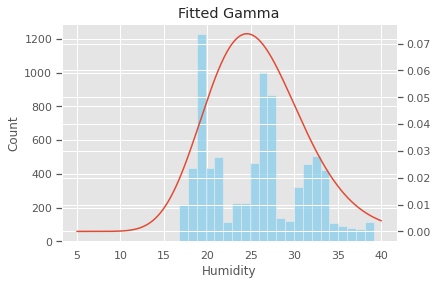

In [ ]:
#Puntos 3b) y 3c)
#Por defecto "fit" usa MLE
sns.histplot(data=data_occupancy["Humidity"], color="skyblue")
x = np.linspace(5,40,1000)
# Gamma
shape, loc, scale = gamma.fit(data_occupancy["Humidity"], floc=0)
print(shape, loc, scale)
y = gamma.pdf(x, shape, loc, scale)
plt.twinx()
plt.title('Fitted Gamma')
plt.plot(x,y)
plt.show()

416.3781900096649 0 0.049519561249321456


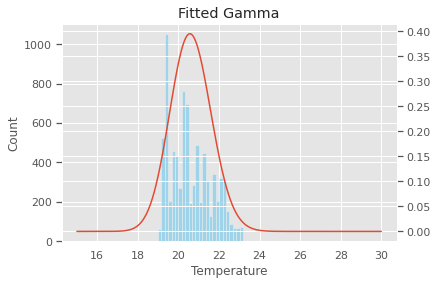

In [ ]:
sns.histplot(data=data_occupancy["Temperature"], color="skyblue")
x = np.linspace(15,30,1000)
# Gamma
shape, loc, scale = gamma.fit(data_occupancy["Temperature"], floc=0)
print(shape, loc, scale)
y = gamma.pdf(x, shape, loc, scale)
plt.twinx()
plt.title('Fitted Gamma')
plt.plot(x,y)
plt.show()

Sin embargo, es imposible determinar si estos datos fueron elegidos de manera aleatoria pues este factor es controlado por la metodología utilizada durante el diseño de este experimento, que en principio desconocemos.

Así mismo, para garantizar generalización es necesario que la muestra haya sido elegida de manera aleatoria. Debido a que desconocemos sí esto es así, por la razón expuesta anteriormente, será insuficiente tener un tamaño de muestra adecuado.

Las respuestas de las preguntas **4)** y **5)** están justificadas en las matrices de confusión implementadas, junto a sus medidas de desempeño y los comentarios presentes en el algoritmo de la support vector machine. 

**6)**

Ahora bien, para garantizar generalización, basta con mirar el desempeño del algoritmo en el conjunto de test. Notesé que hasta el momento solo se ha trabajado con los conjuntos de entrenamiento y validación.  

In [8]:
data_test2=pd.read_csv('datatest2.txt',sep=',',header=0,names=["Date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"],
                               dtype={"Date":str,"Temperature":np.float64,"Humidity":np.float64,"Light":np.float64,
                              "CO2":np.float64,"HumidityRatio":np.float64,"Occupancy":int},parse_dates=[1],infer_datetime_format=True)
data_test2[['Temperature']] = data_test2[['Temperature']].astype(float).round(3)
data_test2["Occupancy"]=data_test2[['Occupancy']].replace(0,-1)

In [9]:
data_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9752 non-null   object 
 1   Temperature    9752 non-null   float64
 2   Humidity       9752 non-null   float64
 3   Light          9752 non-null   float64
 4   CO2            9752 non-null   float64
 5   HumidityRatio  9752 non-null   float64
 6   Occupancy      9752 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 609.5+ KB


Optimized a step
[-1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.

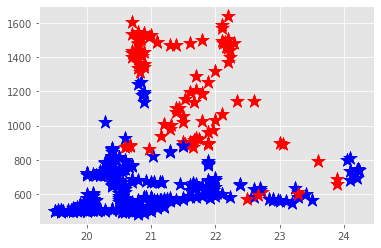

In [10]:
def listOfTuples(l1, l2, l3,l4,l5):
  return list(map(lambda x, y, z, w, t:[x,y,z,w,t], l1, l2, l3,l4,l5))


import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import random
style.use('ggplot')

np.random.seed(56497)




class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1, 1, 1, 1, 1],
                      [1, 1, 1, 1, -1],
                      [1, 1, 1, -1, 1],
                      [1, 1, 1, -1, -1],
                      [1, 1, -1, 1, 1],
                      [1, 1, -1, 1, -1],
                      [1, 1, -1, -1, 1],
                      [1, 1, -1, -1, -1],
                      [1, -1, 1, 1, 1],
                      [1, -1, 1, 1, -1],
                      [1, -1, 1, -1, 1],
                      [1, -1, 1, -1, -1],
                      [1, -1, -1, 1, 1],
                      [1, -1, -1, 1, -1],
                      [1, -1, -1, -1, 1],
                      [1, -1, -1, -1, -1],
                      [-1, 1, 1, 1, 1],
                      [-1, 1, 1, 1, -1],
                      [-1, 1, 1, -1, 1],
                      [-1, 1, 1, -1, -1],
                      [-1, 1, -1, 1, 1],
                      [-1, 1, -1, 1, -1],
                      [-1, 1, -1, -1, 1],
                      [-1, 1, -1, -1, -1],
                      [-1, -1, 1, 1, 1],
                      [-1, -1, 1, 1, -1],
                      [-1, -1, 1, -1, 1],
                      [-1, -1, 1, -1, -1],
                      [-1, -1, -1, 1, 1],
                      [-1, -1, -1, 1, -1],
                      [-1, -1, -1, -1, 1],
                      [-1, -1, -1, -1, -1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        self.max_feature_value_2 = max(data[1][:,0])
        self.min_feature_value_2 = min(data[1][:,0])
        all_data = None

        # support vectors yi(xi.w+b) = 1
        

        step_sizes = [self.max_feature_value * 0.1,
                      #self.max_feature_value * 0.01,
                      # point of expense:
                      #self.max_feature_value * 0.001,
                      ]

        
        
        # extremely expensive
        b_range_multiple = 2
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum,latest_optimum,latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 500:
                                    found_option = False
                                    #print(xi,':',yi*(np.dot(w_t,xi)+b))
                                    
                                if found_option:
                                    opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print("Optimized a step")
                    #print(w)
                    #print(b)
                else:
                    w = w - step


            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            
        # for i in self.data:
        #     for xi in self.data[i]:
        #         yi=i
        #         print(xi,':',yi*(np.dot(self.w,xi)+self.b))
         


    def predict(self,features):
        # sign( x.w+b )
        # x=[]
        # for i in range(0,len(features)):
        #   x.append(features)
        classification = np.sign(np.sum(np.dot(np.array(features),self.w)+self.b+features+750))
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
            #print(features,np.sum(np.dot(np.array(features),self.w)+self.b+features+1200))
        return classification

    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0


        def hyperplane(x,w,b,v):
            return -w[0]*x-b+v

        datarange = (self.min_feature_value_2*0.9,self.max_feature_value_2*1.1)

        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        #(w.x+b) = 1
        #positive support vector hyperplane
        psv1 =hyperplane(hyp_x_min, self.w, self.b,500)
        psv2 =hyperplane(hyp_x_max, self.w, self.b,0)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')


        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -500)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 250)
        db2 = hyperplane(hyp_x_max, self.w, self.b, -250)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()

#"Muestra aleatoria"       
dfa=data_occupancy[data_occupancy["Occupancy"]==1].sample(1000)

dfb=data_occupancy[data_occupancy["Occupancy"]==-1].sample(1000)


data_dict = {-1:np.array(listOfTuples(dfb["Temperature"],dfb["CO2"],dfb["Light"],dfb["Humidity"],dfb["HumidityRatio"])),
             1:np.array(listOfTuples(dfa["Temperature"],dfa["CO2"],dfb["Light"],dfb["Humidity"],dfb["HumidityRatio"]))
             }

svm = Support_Vector_Machine()
svm.fit(data=data_dict)

dt=data_test2.sample(500)

predict_us = listOfTuples(dt["Temperature"],dt["CO2"],dt["Light"],dt["Humidity"],dt["HumidityRatio"])

x=[]

for p in predict_us:
    svm.predict(p)
    x.append(svm.predict(p))
print(x)

#svm.visualize()

In [11]:
#Matriz de confusión
#Punto 5
predicted =pd.Series(list(map(int, x)),name="predicted")
actual=pd.Series(dt["Occupancy"],name="actual").reset_index(drop=True)
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])

df_confusion 
#Accuracy=90.6%
#Accuracy svm() de scikit-learn=85.9%

Predicted,-1,1
Actual,,
-1,368,43
1,28,61


**Descripción del data set bank note**



Estos datos fueron extraídos de imágenes de billetes tanto falsificados como genuinos. Para su digitalización, fue usada una cámara industrial. Las imágenes obtenidas tienen una resolución de 400x400 píxeles. Se hace uso de la transformada wavelet para extraer características relevantes de las imágenes.   

1. Varianza de la transformada Wavelet de la imagen 
2. Simetría de la transformada Wavelet de la imagen
3. Curtosis de la transformada Wavelet de la imagen
4. Entropía de la imagen 
5. Clase: Falso -1, verdadero 1.

In [25]:
data_bank=pd.read_csv('data_banknote_authentication.txt',sep=',',names=["variance","skewness","curtosis","entropy","class"],
                      dtype={"variance":np.float64,"skewness":np.float64,"curtosis":np.float64,
                              "entropy":np.float64,"class":int})
data_bank["class"]=data_bank[['class']].replace(0,-1)

data_bank.describe()

#Separación del conjunto de datos en entrenamiento, validación y testeo.

train, validation, test = np.split(data_bank.sample(frac=1), [int(.6*len(data_bank)),
int(.8*len(data_bank))])

In [30]:
train.shape

(823, 5)

In [16]:
data_bank.apply(missings,axis=0)

,variance,skewness,curtosis,entropy,class
Missings,0.0,0.0,0.0,0.0,0.0
%Missings,0.0,0.0,0.0,0.0,0.0


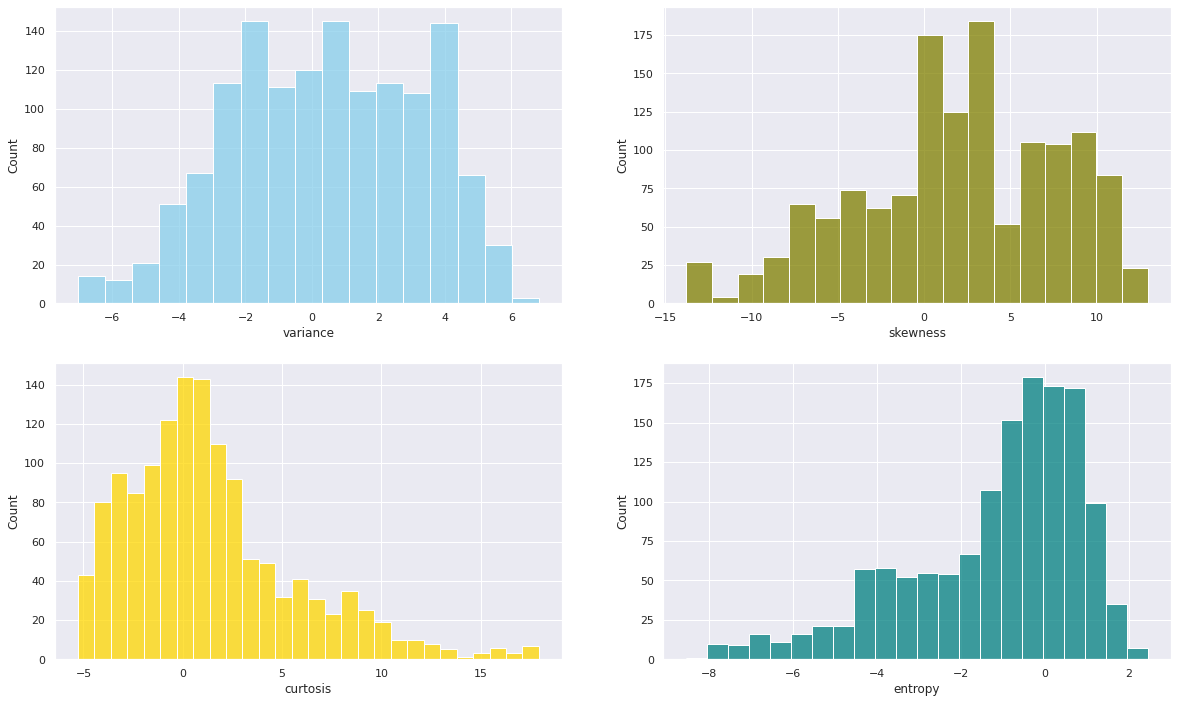

In [18]:
#Frecuencias
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

sns.histplot(data=data_bank["variance"], color="skyblue", ax=axs[0, 0])
sns.histplot(data=data_bank["skewness"], color="olive", ax=axs[0, 1])
sns.histplot(data=data_bank["curtosis"], color="gold", ax=axs[1, 0])
sns.histplot(data=data_bank["entropy"], color="teal", ax=axs[1, 1])
plt.show()

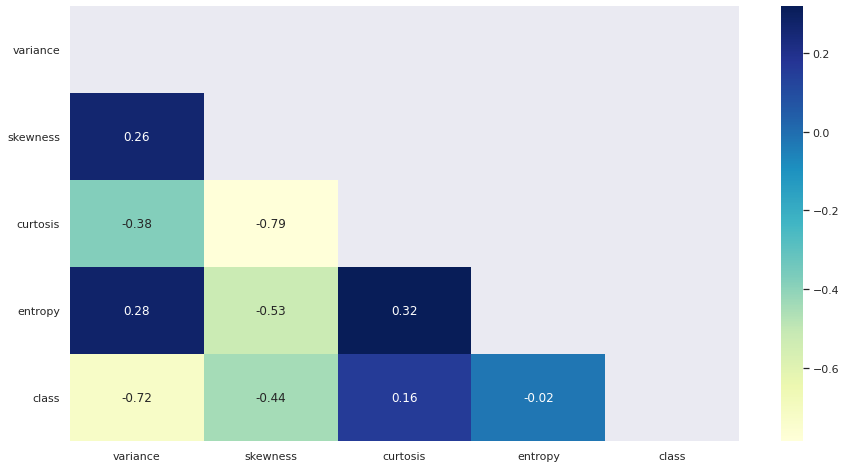

In [19]:
mask = np.triu(np.ones_like(data_bank.corr()))
plt.figure(figsize = (15,8))
sns.heatmap(data_bank.corr(),annot=True, fmt="1.2f", mask=mask, cmap="YlGnBu")
plt.yticks(rotation=0)
plt.show()

In [35]:
#Función para crear las tranformaciones
import itertools
x = [1, -1]
a=[p for p in itertools.product(x, repeat=4)]
b = [list(x) for x in a]
b

[[1, 1, 1, 1],
 [1, 1, 1, -1],
 [1, 1, -1, 1],
 [1, 1, -1, -1],
 [1, -1, 1, 1],
 [1, -1, 1, -1],
 [1, -1, -1, 1],
 [1, -1, -1, -1],
 [-1, 1, 1, 1],
 [-1, 1, 1, -1],
 [-1, 1, -1, 1],
 [-1, 1, -1, -1],
 [-1, -1, 1, 1],
 [-1, -1, 1, -1],
 [-1, -1, -1, 1],
 [-1, -1, -1, -1]]

Optimized a step


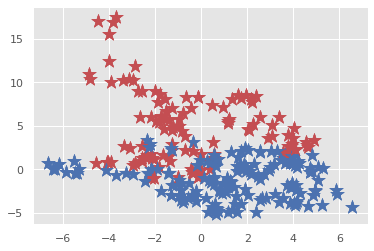

In [157]:
def listOfTuples(l1, l2, l3,l4):
  return list(map(lambda x, y, z, w:[x,y,z,w], l1, l2, l3,l4))


import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import random
style.use('ggplot')

np.random.seed(56497)




class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1, 1, 1, 1],
                      [1, 1, 1, -1],
                      [1, 1, -1, 1],
                      [1, 1, -1, -1],
                      [1, -1, 1, 1],
                      [1, -1, 1, -1],
                      [1, -1, -1, 1],
                      [1, -1, -1, -1],
                      [-1, 1, 1, 1],
                      [-1, 1, 1, -1],
                      [-1, 1, -1, 1],
                      [-1, 1, -1, -1],
                      [-1, -1, 1, 1],
                      [-1, -1, 1, -1],
                      [-1, -1, -1, 1],
                      [-1, -1, -1, -1]]


        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        self.max_feature_value_2 = max(data[1][:,0])
        self.min_feature_value_2 = min(data[1][:,0])
        all_data = None

        # support vectors yi(xi.w+b) = 1
        

        step_sizes = [self.max_feature_value * 0.1,
                      #self.max_feature_value * 0.01,
                      # point of expense:
                      #self.max_feature_value * 0.001,
                      ]

        
        
        # extremely expensive
        b_range_multiple = 2
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum,latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 500:
                                    found_option = False
                                    #print(xi,':',yi*(np.dot(w_t,xi)+b))
                                    
                                if found_option:
                                    opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print("Optimized a step")
                    #print(w)
                    #print(b)
                else:
                    w = w - step


            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            
        # for i in self.data:
        #     for xi in self.data[i]:
        #         yi=i
        #         print(xi,':',yi*(np.dot(self.w,xi)+self.b))
         


    def predict(self,features):
        # sign( x.w+b )
        # x=[]
        # for i in range(0,len(features)):
        #   x.append(features)
        classification = np.sign(np.sum(np.dot(np.array(features),self.w)+self.b+features+48))
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
            #print(features,np.sum(np.dot(np.array(features),self.w)+self.b+features+1200))
        return classification

    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0


        def hyperplane(x,w,b,v):
            return w[0]*x+b-v

        datarange = (self.min_feature_value_2*0.15,self.max_feature_value_2*0.1)

        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        #(w.x+b) = 1
        #positive support vector hyperplane
        psv1 =hyperplane(hyp_x_min, self.w, self.b,0)
        psv2 =hyperplane(hyp_x_max, self.w, self.b,48)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')


        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -48)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, -24)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 24)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()

#"Muestra aleatoria"       
dfa=data_bank[data_bank["class"]==1]

dfb=data_bank[data_bank["class"]==-1]


data_dict = {-1:np.array(listOfTuples(dfb["variance"],dfb["curtosis"],dfb["skewness"],dfb["entropy"])),
             1:np.array(listOfTuples(dfa["variance"],dfa["curtosis"],dfb["skewness"],dfb["entropy"]))
             }

svm = Support_Vector_Machine()
svm.fit(data=data_dict)

dt=test

predict_us = listOfTuples(dt["variance"],dt["curtosis"],dt["skewness"],dt["entropy"])

x=[]

for p in predict_us:
    svm.predict(p)
    x.append(svm.predict(p))


#svm.visualize()

In [146]:
#Matriz de confusión
#Punto 5
predicted =pd.Series(list(map(int, x)),name="predicted")
actual=pd.Series(dt["class"],name="actual").reset_index(drop=True)
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])

df_confusion 
#Accuracy=64.3%


Predicted,-1,1
Actual,,
-1,106,43
1,55,71


Por tener este nivel de precisión tan bajo consideramos que este data set no es linealmente separable. Por esta razón, no medimos el desempeño en el conjunto de test, pues la implementación realizada depende que el conjunto de datos sea linealmente separable.